# Image Segmentation using PyTorch

In this notebook, we will perform image segmentation on images stored in the `data/cam1` directory using a pre-trained U-Net model.

## Step 1: Setup and Imports

Before we import the libraries, we need to install the libraries.

In [ ]:
pip install torch torchvision numpy matplotlib opencv-python

Now we can move onto import the necessary libraries.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import random
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models.segmentation import fcn_resnet50
from PIL import Image

## Step 2: Define the Dataset

We need to define a custom dataset class to handle the images in the `data/cam1` directory.

In [2]:
# Define a simple dataset
class ImageDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
        return image

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

Let's do some basic background before we dive into segmenting our images

In [3]:
# Define the folder containing the images
image_folder = '../data/cam1'

# Load the dataset
dataset = ImageDataset(image_folder=image_folder, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# List all image files in the folder
image_files = [f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]

# Initialize lists to store image information
image_names = []
image_sizes = []
image_dimensions = []

# Iterate through each image file
for image_file in image_files:
    image_path = os.path.join(image_folder, image_file)
    with Image.open(image_path) as img:
        # Get image size and dimensions
        image_size = os.path.getsize(image_path)
        image_dimension = img.size

        # Append information to lists
        image_names.append(image_file)
        image_sizes.append(image_size)
        image_dimensions.append(image_dimension)

# Create a DataFrame to store the information
df = pd.DataFrame({
    'Image Name': image_names,
    'File Size (bytes)': image_sizes,
    'Dimensions': image_dimensions
})

# Display the first few rows of the DataFrame
print(df.head())

                     Image Name  File Size (bytes)   Dimensions
0   date_1-6-2024_10.0.11_1.png            2197936  (1280, 928)
1  date_16-5-2024_10.0.10_1.png            2660533  (1280, 928)
2   date_5-6-2024_10.0.10_1.png            2647447  (1280, 928)
3  date_23-5-2024_13.0.11_1.png            2544996  (1280, 928)
4  date_25-5-2024_10.0.11_1.png            2549263  (1280, 928)


In [4]:
# Display some basic statistics
print(f"Total number of images: {len(image_files)}")
print(f"Average file size: {df['File Size (bytes)'].mean()} bytes")
print(f"Average dimensions: {pd.DataFrame(image_dimensions).mean().astype(int).values}")

Total number of images: 86
Average file size: 2459606.5581395347 bytes
Average dimensions: [1280  928]


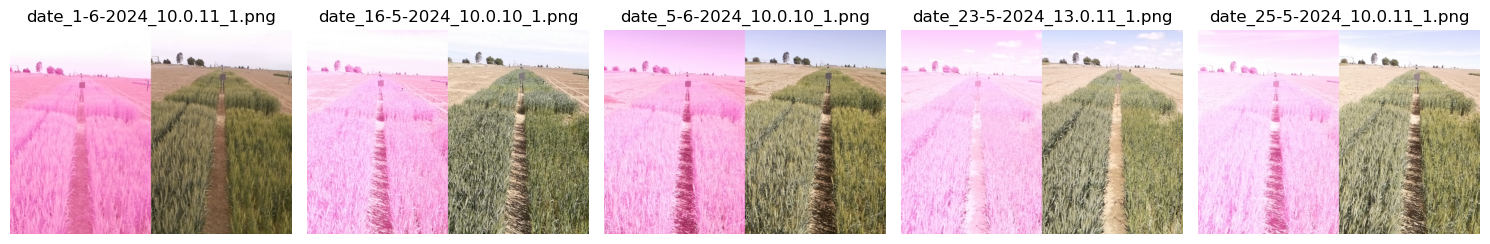

In [5]:
# Plot the first few images
num_images_to_display = 5
plt.figure(figsize=(15, 5))
for i in range(min(num_images_to_display, len(image_files))):
    image_path = os.path.join(image_folder, image_files[i])
    img = Image.open(image_path)
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(img)
    plt.title(image_files[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

## Step 3: Load a Pre-trained Model

We will use a pre-trained Fully Convolutional Network (FCN) for segmentation.

In [6]:
# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the pre-trained FCN model
model = fcn_resnet50(pretrained=True)
model = model.to(device)
model.eval()

/Users/vjeyam/miniconda3/envs/sensor/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/vjeyam/miniconda3/envs/sensor/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

## Step 4: Perform Segmentation and Visualize Results

We will iterate over the images, perform segmentation, and visualize the results.

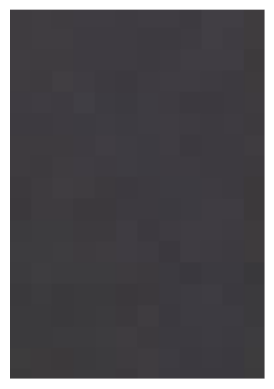

In [7]:
import matplotlib.image as mpimg

# Load and display the image
img = mpimg.imread('../data/plot_tool.png')
plt.imshow(img)
plt.axis('off')
plt.show()

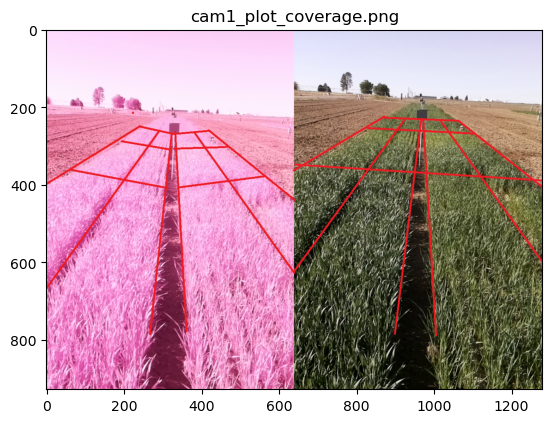

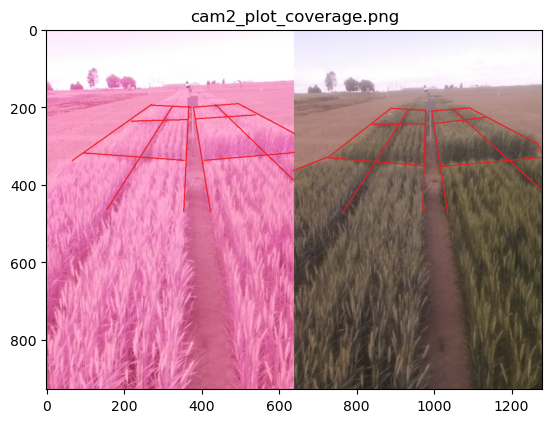

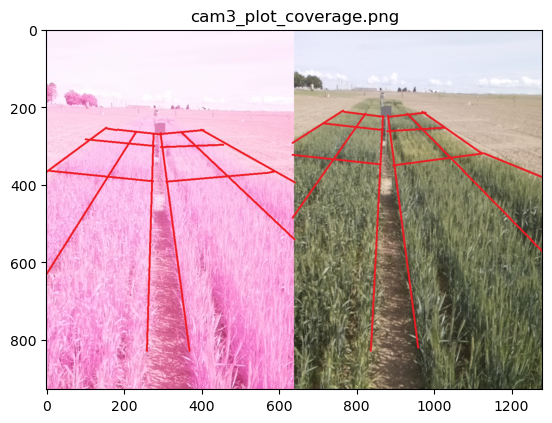

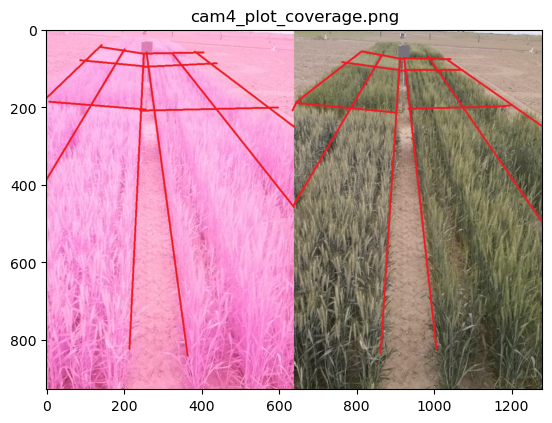

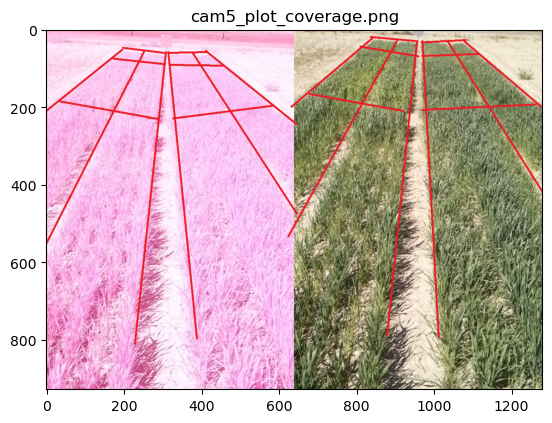

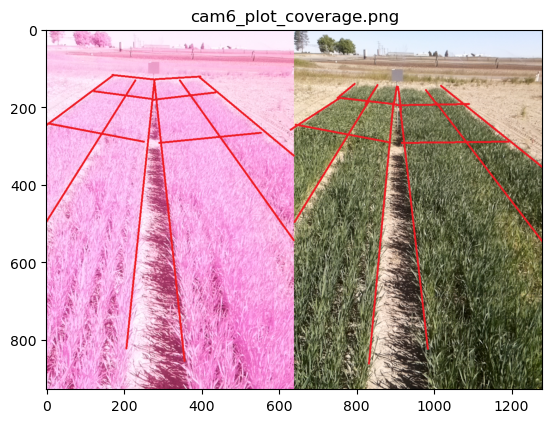

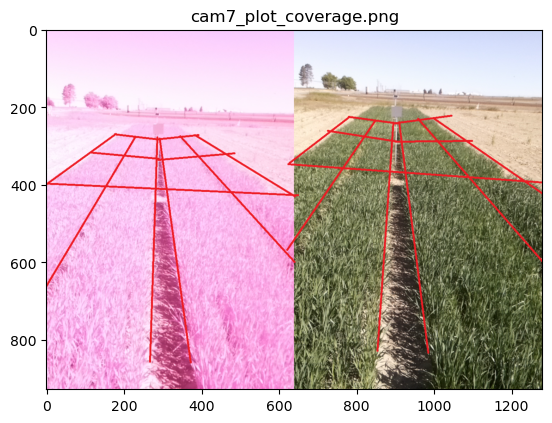

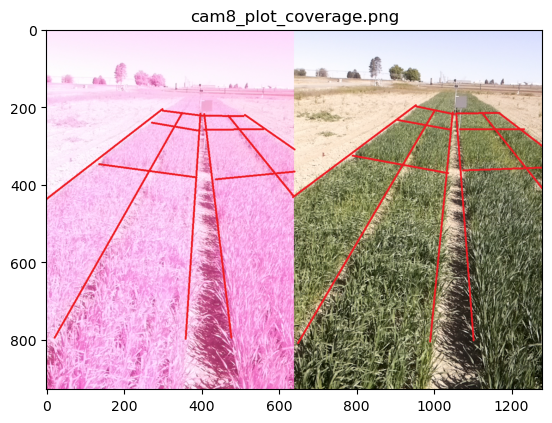

In [8]:
path = '../data/'
image_files = [path + 'cam1_plot_coverage.png', path + 'cam2_plot_coverage.png', path + 'cam3_plot_coverage.png',
               path + 'cam4_plot_coverage.png', path + 'cam5_plot_coverage.png', path + 'cam6_plot_coverage.png',
               path + 'cam7_plot_coverage.png', path + 'cam8_plot_coverage.png']

# Assuming 'image_files' is the list of image file names
for image_file in image_files:
    # Load the image
    img = plt.imread(image_file)

    # Display the image with the title as the image file name
    plt.imshow(img)
    image_file = image_file.replace('../data/', '')
    plt.title(image_file)
    plt.show()


## Splitting 928x1280 image into 2 928x640 images

In [14]:
# Define the transformations
transform = transforms.Compose([
    transforms.Resize((928, 1280)),
    transforms.ToTensor(),
])

class ImageDataset(Dataset):
    def __init__(self, image_folder, transform=None):
        self.image_folder = image_folder
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

def split_image(image):
    left_image = image[:, :, :640]
    right_image = image[:, :, 640:]
    return left_image, right_image

# Load the dataset
dataset_folder = '../data/cam1'
output_folder = '../data/cam1_split'
os.makedirs(output_folder, exist_ok=True)
dataset = ImageDataset(image_folder=dataset_folder, transform=transform)

Now let's randomly display 5 to 10 images from our new directory `data/cam1_split`

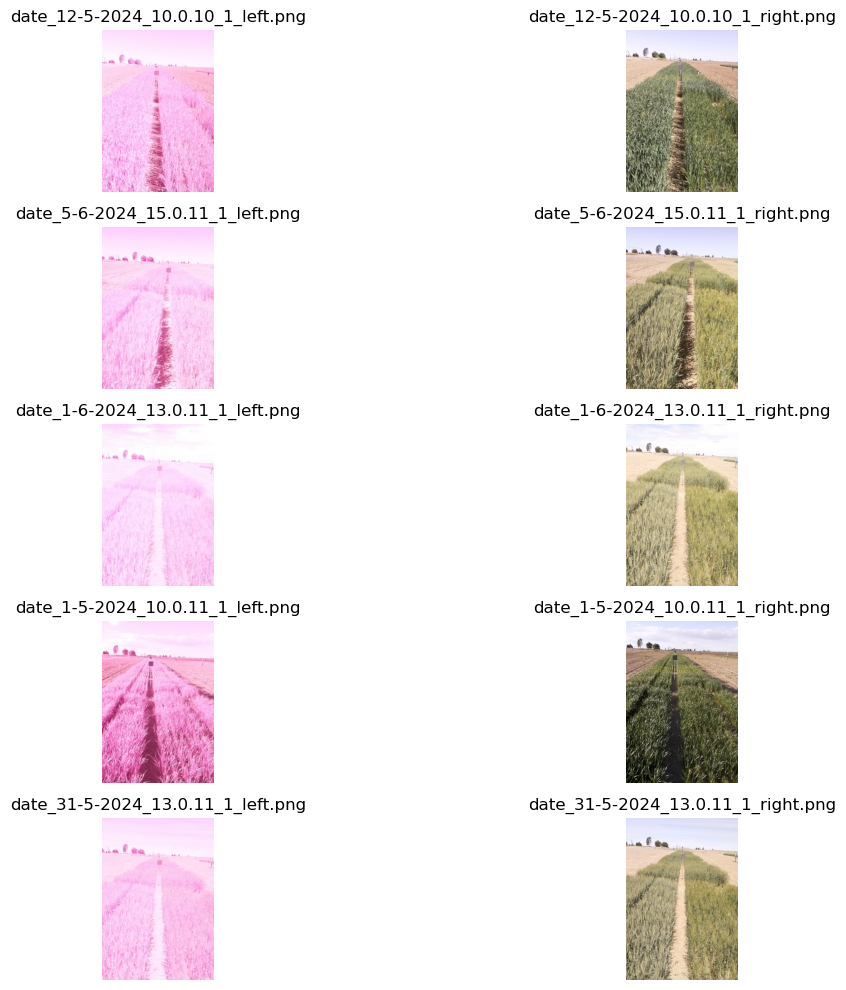

In [15]:
# Get a random sample of 5 to 10 images
num_images_to_display = random.randint(5, 10)
random_images = random.sample(range(len(dataset)), num_images_to_display)

# Iterate through the selected images, split them, and display them
plt.figure(figsize=(15, 10))
for i, idx in enumerate(random_images):
    image = dataset[idx]  # Get image as a tensor
    left_image, right_image = split_image(image)

    # Convert tensors back to PIL Images
    left_image_pil = transforms.ToPILImage()(left_image)
    right_image_pil = transforms.ToPILImage()(right_image)

    # Save the split images
    base_filename = os.path.splitext(dataset.image_files[idx])[0]
    left_image_pil.save(os.path.join(output_folder, f"{base_filename}_left.png"))
    right_image_pil.save(os.path.join(output_folder, f"{base_filename}_right.png"))

    # Plot the left image
    plt.subplot(num_images_to_display, 2, i*2+1)
    plt.imshow(left_image_pil)
    plt.title(f"{base_filename}_left.png")
    plt.axis('off')

    # Plot the right image
    plt.subplot(num_images_to_display, 2, i*2+2)
    plt.imshow(right_image_pil)
    plt.title(f"{base_filename}_right.png")
    plt.axis('off')

plt.tight_layout()
plt.show()

Let's now find how many images we have in our new directory: `data/cam1_split`.

In [16]:
image_folder = '../data/cam1_split'
image_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]
num_images = len(image_files)
print(f"Number of images in cam1_split: {num_images}")

Number of images in cam1_split: 10


The script starts by defining two main folders: `split_folder` for input images split into left and right halves, and `output_folder` where combined images will be saved. It ensures that the output folder exists or creates it if not.

Next, it retrieves lists of filenames ending with '_left.png' and '_right.png' from the `split_folder`, sorting them to ensure corresponding left and right images are processed together.

In a loop, each pair of left and right images is processed:

1. Images are loaded from their respective paths using Pillow's `Image.open`.

2. An initial check ensures both images are of the same dimensions; if not, it skips processing and prints a message.

3. A mask is created from the right image (assumed to be in the red channel) to define areas to overlay on the left image.

4. A new RGB image (`combined_image`) is created with dimensions matching the original halves.

5. The left image is pasted onto `combined_image` at the top-left corner.

6. The right image is overlaid on `combined_image` using the created mask, ensuring only selected areas are applied.

``` python
# Create a new blank image with the same size as the original halves (928x640)
combined_image = Image.new('RGB', (left_image.width, left_image.height))

# Paste the left image
combined_image.paste(left_image, (0, 0))

# Create a mask from the right image (use the red channel for simplicity)
right_mask = right_image.convert("L")  # Convert right image to grayscale for mask

# Paste the right image on top using the mask
combined_image.paste(right_image, (0, 0), mask=right_mask)
```

7. The resulting combined image is saved in `output_folder` with a modified filename derived from the original left image.

8. Throughout the process, exceptions are caught using a `try-except` block to handle potential errors gracefully, printing specific error messages if processing fails for any pair.

9. Once all pairs are processed or skipped, a completion message is printed indicating the script has finished combining images.

This script is designed to batch process pairs of split images, ensuring compatibility and handling errors to streamline the creation of combined images suitable for further analysis or visualization.


In [17]:
# Define the folders
split_folder = '../data/cam1_split'
output_folder = '../data/cam1_combined'
os.makedirs(output_folder, exist_ok=True)

# Get the list of left and right images
left_images = [f for f in os.listdir(split_folder) if f.endswith('_left.png')]
right_images = [f for f in os.listdir(split_folder) if f.endswith('_right.png')]

# Ensure that we have matching left and right images
left_images.sort()
right_images.sort()

for left_image_name, right_image_name in zip(left_images, right_images):
    try:
        # Load the images
        left_image_path = os.path.join(split_folder, left_image_name)
        right_image_path = os.path.join(split_folder, right_image_name)
        left_image = Image.open(left_image_path)
        right_image = Image.open(right_image_path)

        # Ensure both images are of the same size
        if left_image.size != right_image.size:
            print(f"Skipping {left_image_name} and {right_image_name} due to size mismatch.")
            continue

        # Create a mask from the right image (use the red channel for simplicity)
        right_mask = right_image.convert("L")  # Convert right image to grayscale for mask

        # Create a new blank image with the same size as the original halves (928x640)
        combined_image = Image.new('RGB', (left_image.width, left_image.height))

        # Paste the left image
        combined_image.paste(left_image, (0, 0))

        # Paste the right image on top using the mask
        combined_image.paste(right_image, (0, 0), mask=right_mask)

        # Save the combined image
        base_filename = left_image_name.replace('_left.png', '')
        combined_image.save(os.path.join(output_folder, f"{base_filename}.png"))

        print(f"Processed {left_image_name} and {right_image_name}")

    except Exception as e:
        print(f"Error processing {left_image_name} and {right_image_name}: {str(e)}")

print("Image combination complete.")

Processed date_1-5-2024_10.0.11_1_left.png and date_1-5-2024_10.0.11_1_right.png
Processed date_1-6-2024_13.0.11_1_left.png and date_1-6-2024_13.0.11_1_right.png
Processed date_12-5-2024_10.0.10_1_left.png and date_12-5-2024_10.0.10_1_right.png
Processed date_31-5-2024_13.0.11_1_left.png and date_31-5-2024_13.0.11_1_right.png
Processed date_5-6-2024_15.0.11_1_left.png and date_5-6-2024_15.0.11_1_right.png
Image combination complete.


Now let's display our combined images, found in the `data/cam1_combined` directory.

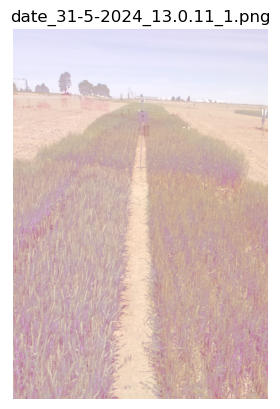

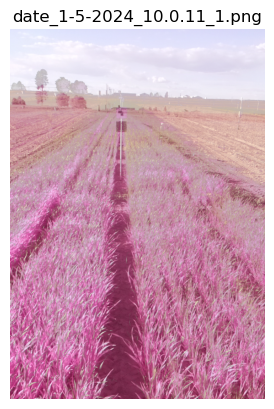

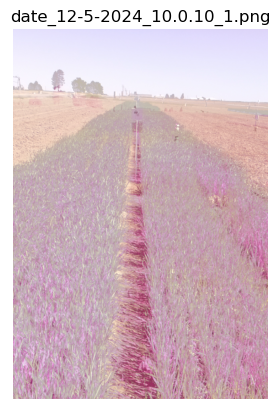

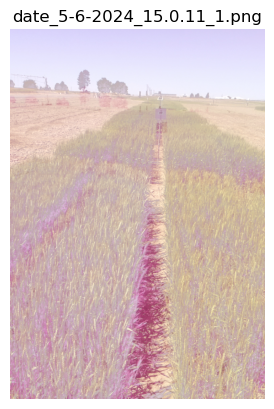

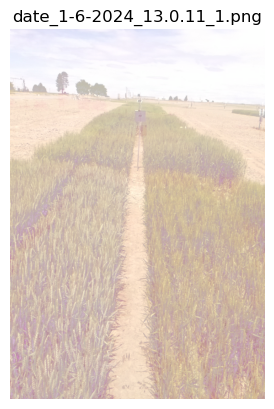

In [18]:
# Define the directory path
directory = '../data/cam1_combined'

# Get the list of image files
image_files = [f for f in os.listdir(directory) if f.endswith('.png')]

# Iterate through the image files and display them
for image_file in image_files:
    # Load the image
    image_path = os.path.join(directory, image_file)
    image = plt.imread(image_path)

    # Display the image
    plt.imshow(image)
    plt.title(image_file)
    plt.axis('off')
    plt.show()